In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

alpha = 110
length = 50 # length of the plate, 50 mm
time = 2 # total time, 10 s
nodes = 10 # number of nodes - 1

dx = length / nodes # distance between nodes
dy = length / nodes # distance between nodes
# time step, must be less or equal to than min of dx^2 / (4 * alpha) and dy^2 / (4 * alpha)
dt = np.min([0.25 * dx**2 / alpha, 0.25 * dy**2 / alpha]) 

x_train = np.linspace(0, length, nodes)
y_train = np.linspace(0, length, nodes)
t_train = np.linspace(0, time, int(time / dt))

u = np.zeros((nodes, nodes)) + 20 # middle of the plate is 20 degrees
# for i in range(len(u[0, :])): # top ranges from 20 to 78 degrees linearly
#     u[0, i] = 20 + 3*i
u[0, :] = 100 # bottom side of the plate is 100 degrees
# u[-1, :] = 100 # top side of the plate is 100 degrees
# u[:, 0] = 100 # left side of the plate is 100 degrees
# u[:, -1] = 100 # right side of the plate is 100 degrees

heat_data = np.zeros((int(time / dt), nodes, nodes))

for counter in range(heat_data.shape[0]):
    w = u.copy()

    for i in range(1, nodes - 1):
        for j in range(1, nodes - 1):
            dd_ux = (w[i - 1, j] - 2 * w[i, j] + w[i + 1, j]) / dx**2
            dd_uy = (w[i, j - 1] - 2 * w[i, j] + w[i, j + 1]) / dy**2

            u[i, j] = dt * alpha * (dd_ux + dd_uy) + w[i, j]

    heat_data[counter, :, :] = u.copy()

    print(f't: {counter * dt:.3f} s, Ave temp: {np.mean(u):.2f} C')

print(heat_data.shape)

t: 0.000 s, Ave temp: 29.60 C
t: 0.057 s, Ave temp: 30.70 C
t: 0.114 s, Ave temp: 31.57 C
t: 0.170 s, Ave temp: 32.31 C
t: 0.227 s, Ave temp: 32.94 C
t: 0.284 s, Ave temp: 33.50 C
t: 0.341 s, Ave temp: 34.00 C
t: 0.398 s, Ave temp: 34.45 C
t: 0.455 s, Ave temp: 34.86 C
t: 0.511 s, Ave temp: 35.24 C
t: 0.568 s, Ave temp: 35.59 C
t: 0.625 s, Ave temp: 35.92 C
t: 0.682 s, Ave temp: 36.22 C
t: 0.739 s, Ave temp: 36.50 C
t: 0.795 s, Ave temp: 36.77 C
t: 0.852 s, Ave temp: 37.01 C
t: 0.909 s, Ave temp: 37.24 C
t: 0.966 s, Ave temp: 37.46 C
t: 1.023 s, Ave temp: 37.66 C
t: 1.080 s, Ave temp: 37.85 C
t: 1.136 s, Ave temp: 38.03 C
t: 1.193 s, Ave temp: 38.20 C
t: 1.250 s, Ave temp: 38.36 C
t: 1.307 s, Ave temp: 38.50 C
t: 1.364 s, Ave temp: 38.64 C
t: 1.420 s, Ave temp: 38.77 C
t: 1.477 s, Ave temp: 38.89 C
t: 1.534 s, Ave temp: 39.01 C
t: 1.591 s, Ave temp: 39.12 C
t: 1.648 s, Ave temp: 39.22 C
t: 1.705 s, Ave temp: 39.31 C
t: 1.761 s, Ave temp: 39.40 C
t: 1.818 s, Ave temp: 39.49 C
t: 1.875 s

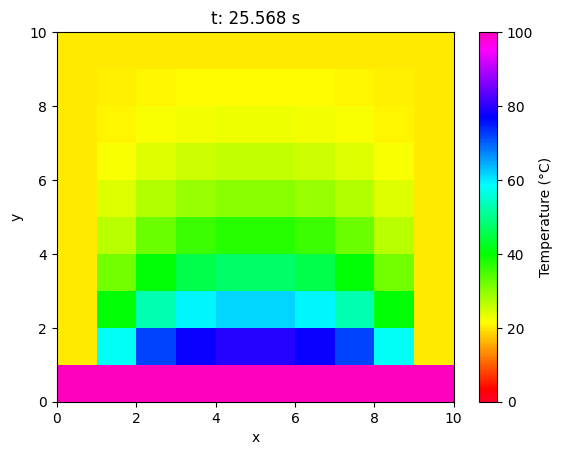

In [43]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(heat_data[25, :, :], cmap='gist_rainbow', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f't: {450*dt:.3f} s')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [45]:
import os
import sys

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

In [11]:
from deep_learning import deep_network_core as core, utils
import torch
import torch.nn as nn
from torch.autograd import grad as autograd

In [ ]:
# torch.manual_seed(1234)
# np.random.seed(1234)

Tr, Xr, Yr = np.meshgrid(t_train, x_train, y_train)

inpt = np.column_stack((Tr.ravel(), Xr.ravel(), Yr.ravel()))
oupt = heat_data.ravel()

In [26]:
class MSE_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.MSELoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

In [ ]:
network_pinn = core.PINN(3, 1, 64, 3, [(1, MSE_Loss())])

In [51]:
print("Training NN")
network_pinn.fit(inpt, oupt, lr=1e-2, epochs=10000)

Training NN
Epoch 1/10000 loss: 2e+03
Epoch 1000/10000 loss: 6.3e+02
Epoch 2000/10000 loss: 6.1e+02
Epoch 3000/10000 loss: 5.1e+02
Epoch 4000/10000 loss: 3.8e+02
Epoch 5000/10000 loss: 3.3e+02
Epoch 6000/10000 loss: 2.8e+02
Epoch 7000/10000 loss: 2.1e+02
Epoch 8000/10000 loss: 2.2e+02
Epoch 9000/10000 loss: 2.2e+02
Epoch 10000/10000 loss: 1.7e+02


[2012.64404296875,
 1912.0576171875,
 1639.3851318359375,
 1085.7811279296875,
 1064.6083984375,
 893.677001953125,
 828.6370849609375,
 906.2992553710938,
 912.4413452148438,
 849.8564453125,
 807.0784912109375,
 863.8115844726562,
 859.5474853515625,
 806.92822265625,
 812.8082275390625,
 832.5570068359375,
 825.414306640625,
 801.7877807617188,
 802.7932739257812,
 813.328369140625,
 797.27001953125,
 791.3049926757812,
 796.9147338867188,
 797.5499267578125,
 789.6723022460938,
 784.8775634765625,
 788.0672607421875,
 786.3822021484375,
 778.69384765625,
 777.18798828125,
 778.320556640625,
 775.186279296875,
 770.4143676757812,
 769.1972045898438,
 769.24072265625,
 766.4772338867188,
 764.1305541992188,
 762.9468383789062,
 761.2744140625,
 759.4659423828125,
 754.8956298828125,
 753.2380981445312,
 749.5928344726562,
 749.8662109375,
 745.7459716796875,
 744.8825073242188,
 740.8176879882812,
 739.08447265625,
 735.4869995117188,
 732.9751586914062,
 730.095947265625,
 726.01934

In [54]:
network_dgm = core.DGM(3, 1, 128, 4, [(1, MSE_Loss())])
print("Training DGM")
network_dgm.fit(inpt, oupt, lr=1e-2, epochs=1000)

Training DGM
Epoch 1/1000 loss: 2.8e+03
Epoch 100/1000 loss: 6.8e+02
Epoch 200/1000 loss: 6.4e+02
Epoch 300/1000 loss: 6.4e+02
Epoch 400/1000 loss: 6.3e+02
Epoch 500/1000 loss: 6.3e+02
Epoch 600/1000 loss: 6.3e+02
Epoch 700/1000 loss: 6.3e+02
Epoch 800/1000 loss: 6.2e+02
Epoch 900/1000 loss: 6.2e+02
Epoch 1000/1000 loss: 6.2e+02


[2761.45166015625,
 1973.5186767578125,
 1394.356201171875,
 1019.7034301757812,
 840.4385986328125,
 832.0794067382812,
 937.0269165039062,
 1063.4315185546875,
 1138.6055908203125,
 1142.4241943359375,
 1090.935791015625,
 1012.3209838867188,
 932.4715576171875,
 868.7739868164062,
 829.2177124023438,
 813.9804077148438,
 817.994140625,
 833.8206176757812,
 853.930908203125,
 872.1497802734375,
 884.3809204101562,
 888.6664428710938,
 884.9405517578125,
 874.5726928710938,
 859.8569946289062,
 843.5014038085938,
 828.1412353515625,
 815.93994140625,
 808.1970825195312,
 805.1890869140625,
 806.332275390625,
 810.3084106445312,
 815.383544921875,
 819.3621215820312,
 820.6422729492188,
 819.0341186523438,
 815.0361328125,
 809.7857055664062,
 804.0341186523438,
 798.8591918945312,
 794.9262084960938,
 791.9762573242188,
 789.751220703125,
 788.3029174804688,
 787.1505126953125,
 785.8076171875,
 784.4717407226562,
 783.2090454101562,
 782.0088500976562,
 780.6832275390625,
 779.065795